## Grid Search for HyperParameter Tuning

This part is used to show the process of hyper parameter tuning for ridge regression using grid search.

### Data loading and feature selection

The first part is data loading and feature selection, which is the same as in the main.ipynb file. We read data, separate them into three groups according to jet_num and then drop features which are not defined or are highly correlated.

In [16]:
# import basic packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# import self-defined modules
from implementations import *
from tools import *
from helpers import *

# just to ingore warning
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

In [3]:
data_path_tr = 'data/train.csv'
yb_tr, data_tr, idx_tr, labels = load_csv_data(data_path_tr, sub_sample=False)

# prepare the data using self-defined DataFrame class
labels_dataframe = ['Prediction'] + labels
data_tr_dataframe = np.concatenate((yb_tr.reshape([-1,1]), data_tr), axis=1)
dataframe_tr = DataFrame(data_tr_dataframe, idx_tr.tolist(), labels_dataframe)

In [4]:
DER_mode_s =119.89
DER_mode_b =96.819

# replace -999（undefined values of 'DER_mass_MMC'） with mode respectively
temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']==-999)
temp = temp.loc(temp['Prediction']==1)
dataframe_tr.loc(temp.index)['DER_mass_MMC'] = DER_mode_s

temp = dataframe_tr.loc(dataframe_tr['DER_mass_MMC']==-999)
temp = temp.loc(temp['Prediction']==-1)
dataframe_tr.loc(temp.index)['DER_mass_MMC'] = DER_mode_b

In [5]:
feature_dorp_phi = ['PRI_jet_leading_phi',
                    'PRI_jet_subleading_phi',
                    'PRI_lep_phi',
                    'PRI_met_phi',
                    'PRI_tau_phi',]
dataframe_tr = dataframe_tr.drop(feature_dorp_phi)

In [6]:
def group_features_by_jet(dataframe):
    return {  
        0: dataframe.loc( dataframe['PRI_jet_num'] == 0).copy(),
        1: dataframe.loc( dataframe['PRI_jet_num'] == 1).copy(),
        2: dataframe.loc((dataframe['PRI_jet_num'] == 2) | (dataframe['PRI_jet_num'] == 3)).copy(),
    }
dataframe_tr_grp = group_features_by_jet(dataframe_tr)

In [7]:
# calculate missing rate 
def missing_rate(dataframe, miss_number):
    features = dataframe.drop(['Prediction'])
    missing_rate = []
    for feature in features.labels:
        data = features.loc(features[feature] ==  miss_number)
        if data.values.size != 0:
            missing_rate.append(data[feature].size / features[feature].size)
        else:
            missing_rate.append(0)
    missing_rate = np.array(missing_rate).reshape([1, -1]).squeeze()
    missing_rate_labels = dataframe.labels[1:]
    return DataFrame(missing_rate, [0], missing_rate_labels)

# get features with undefined values
dataframe_tr_feature_undefined = []
for i in range(len(dataframe_tr_grp)):
    dataframe_tr_miss = missing_rate(dataframe_tr_grp[i], -999)
    dataframe_tr_feature_undefined.append(np.array(dataframe_tr_miss.labels)[dataframe_tr_miss.values == 1].tolist())

In [8]:
# drop features with undefined values in each group
dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(dataframe_tr_feature_undefined[0])
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop(dataframe_tr_feature_undefined[1])
# group2 have no feature with undefined values so we donot need to drop it 

In [9]:
dataframe_tr_feature_zero = []
for i in range(len(dataframe_tr_grp)):
    dataframe_tr_miss = missing_rate(dataframe_tr_grp[i], 0)
    dataframe_tr_feature_zero.append(np.array(dataframe_tr_miss.labels)[dataframe_tr_miss.values == 1].tolist())

In [10]:
# drop features with undefined values in each group
# Because only the first group has all zeros column other than 'PRI_jet_num'
# here we only need to drop first group with dataframe_tr_feature_zero
dataframe_tr_grp[0] = dataframe_tr_grp[0].drop(dataframe_tr_feature_zero[0])

# drop feature 'PRI_jet_num' which is already used for grouping
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop('PRI_jet_num')
dataframe_tr_grp[2] = dataframe_tr_grp[2].drop('PRI_jet_num')

In [11]:
# drop feature 'PRI_jet_num' which is already used for grouping
dataframe_tr_grp[1] = dataframe_tr_grp[1].drop('PRI_jet_num')
dataframe_tr_grp[2] = dataframe_tr_grp[2].drop('PRI_jet_num')

In [18]:
pd.DataFrame(dataframe_tr_grp[0].values)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.0,143.905,81.417,80.943,0.414,3.310,0.414,75.968,2.354,-1.285,22.647,-1.655,53.321,-0.522,31.082,86.062
1,-1.0,175.864,16.915,134.805,16.405,3.891,16.405,57.983,1.056,-1.385,28.209,-2.197,29.774,0.798,2.723,53.131
2,-1.0,105.594,50.559,100.989,4.288,2.904,4.288,65.333,0.675,-1.366,39.008,2.433,26.325,0.210,37.791,129.804
3,-1.0,96.819,86.240,79.692,27.201,2.338,27.201,81.734,1.750,-1.412,29.718,-0.866,52.016,0.126,51.276,250.178
4,-1.0,82.488,31.663,64.128,8.232,2.823,8.232,58.649,1.303,-1.414,25.470,-0.654,33.179,-1.665,12.439,163.420
5,-1.0,96.819,109.412,14.398,17.323,0.472,17.323,62.565,1.774,-0.272,22.552,1.389,40.013,1.856,75.197,198.616
6,1.0,111.026,32.096,75.271,23.067,3.205,23.067,69.649,1.276,-1.414,30.606,-1.107,39.043,-1.944,19.959,122.176
7,1.0,127.861,50.953,77.267,26.967,2.833,26.967,79.503,1.586,1.401,30.739,-0.635,48.764,-0.343,17.557,211.720
8,-1.0,96.819,85.186,68.827,5.042,2.116,5.042,71.443,1.558,-1.351,27.931,1.175,43.512,2.332,44.698,151.816
9,-1.0,96.819,88.767,115.058,15.337,2.879,15.337,58.211,0.875,-1.395,31.046,1.380,27.165,-1.486,72.981,115.145


In [26]:
dataframe_tr_grp[0].values.shape

(99913, 16)

### Starting Grid Search 

After loading data and selecting features, now we can start parameter tuning on polynomial degree and lambda for ridge regression. Grid search is an exhaustive searching method, which tries every possible combination of parameters and find the combination of best performation. Here we define functions `grid_serach` and `ridge_grid_search` to implement grid search and function `get_best_parameters` to return best parameters based on test set accuracy.

In [19]:
def get_best_parameters(para1,para2, acc):
    """
    Get the best degree and lambda from the result of grid search.
    
    Inputs:
        para1,para2:
        Range of parameters in numpy.array.
        
        acc:
        Accuracy matrix saving the accuracy of each 
    
    """
    max_row, max_col = np.unravel_index(np.argmax(acc), acc.shape)
    return acc[max_row, max_col], para1[max_row], para2[max_col]

In [20]:
def grid_search(y, tx, para1, para2):
    """
    Function implements grid search.
    
    Inputs:
        y,tx:
        Label and data for model training.
        
        para1,para2:
        Range of parameters in numpy.array.
    
    Result:
        acc_tr,acc_te:
        Average accuracy of 10-fold cross validation for training set and test set.
    """
    acc_tr = np.zeros((len(para1), len(para2)))
    acc_te = np.zeros((len(para1), len(para2)))
    tx = log_process(tx)
    # k_indices = build_k_indices(y, k_fold=3, seed=1)
    for i in range(0,len(para1)):
        for j in range(0,len(para2)):
            tx,_,_ = standardize(tx)
            tx_poly = build_poly(tx, para1[i])
            # tx_poly,_,_ = standardize(tx_poly)
            lambda_ = para2[j]
            #_,acc_tr[i][j],acc_te[i][j] = cross_validation(y, tx_poly, k_indices, k=0, regression_method=ridge_regression, lambda_=lambda_)
            _,acc_tr[i][j],acc_te[i][j] = cv_loop(y=y, x=tx_poly, k_fold=3, seed=10, regression_method=ridge_regression, lambda_=lambda_)
    return acc_tr,acc_te

In [27]:
def ridge_grid_search(degrees,lambdas):
    """
    The function is used for hyper parameter tuning for ridge regression using grid search.
    
    Inputs:
        degrees: 
        Numpy.array. Degrees range for grid search.
        
        lambdas: 
        Numpy.array. Lambdas range for grid search.
        
    Return:
        The average accuracy of 10-fold cross validation of training set and test set.
    """
    acc_tr = []
    acc_te = []
    for i in range(len(dataframe_tr_grp)):
        tx = dataframe_tr_grp[i].drop('Prediction').values
        # tx = feature_tr_grp[i].drop(columns = ['Id','Prediction']).values
        y = (dataframe_tr_grp[i])['Prediction']
        # y = feature_tr_grp[i].Prediction.replace(['s','b'],[1,-1]).values
        acc_tr_tmp,acc_te_tmp = grid_search(y,tx,degrees,lambdas)
        acc_tr.append(acc_tr_tmp)
        acc_te.append(acc_te_tmp)
    return acc_tr,acc_te

We set the degrees from 1 to 14, and lambdas = 0.0005,0.001,0.01,0.1, then we run ridge regression exhaustively using every possible combination of degree and lambdas.

In [23]:
degrees = np.arange(14)+1
lambdas = [0.0005,0.001,0.01,0.1]
acc_tr,acc_te = ridge_grid_search(degrees,lambdas)

KeyboardInterrupt: 

In [24]:
def plot_gridsearch(acc_tr,acc_te,degrees,lambdas):
    """
    This function is used to plot the result of grid search on accuracy over different values of hyper parameters.
    
    Inputs:
        acc_tr,acc_te: 
        The average accuracy of 10-fold cross validation of training set and test set.
        
        degrees,lambdas:
        Numpy.array. Degrees and lambdas range for grid search.
    """
    fig,ax = plt.subplots(3,4,figsize = (30,30))
    ax = ax.ravel()
    idx = 0

    for j in range(len(acc_tr)):
        for i in range(acc_tr[0].shape[1]):
            ax[idx].plot(degrees, acc_tr[j][:,i], color='r', marker='s', label="Train Accuray" )
            ax[idx].plot(degrees, acc_te[j][:,i], color='b', marker='v', label="Test Accuracy" )
            ax[idx].plot(degrees, (acc_te[j][:,i]+acc_tr[j][:,i])/2, color='g', marker='^', label="Average Accuracy" )
            ax[idx].set_title('Lambda = '+str(lambdas[i]))
            ax[idx].set_xlabel('Degree',size=15)
            ax[idx].set_ylabel('Accuracy',size=15)
            ax[idx].legend()
            idx = idx + 1
        acc,degree,lambda_ = get_best_parameters(degrees,lambdas, acc_te[j])
        print("For group jet_num = {j}, best test accuracy={acc}, poly degree={degree}, lambda={lambda_}".format(j = j,acc=acc, degree=degree, lambda_ = lambda_))
    fig.suptitle('Grid Search Result over Polynomial Degree and Lambda',size=30,y=0.93)
    fig.text(0.5, 0.9, 'Group jet_num = 0', ha='center', va='center',size = 25)
    fig.text(0.5, 0.63, 'Group jet_num = 1', ha='center', va='center',size = 25)
    fig.text(0.5, 0.35, 'Group jet_num = 2,3', ha='center', va='center',size = 25)
    fig.subplots_adjust(hspace=.5)

From the plotting below we can see how the accuracy on test set changes according to the change of degree and lambda. 

The `plot_gridsearch` also returns the parameter combination of best test set accuracy. And we notice that the highest accuracy under lambda = 0.001 is very close to that of lambda = 0.0005. So, to avoid overfitting we decide to use higher `lambda = 0.001`, and choose the `degree = 11, 10, 11` respectively for each group as the best parameters.

For group jet_num = 0, best test accuracy=0.8540815918007846, poly degree=11, lambda=0.0005
For group jet_num = 1, best test accuracy=0.8197023625296606, poly degree=10, lambda=0.001
For group jet_num = 2, best test accuracy=0.850943578291496, poly degree=12, lambda=0.0005


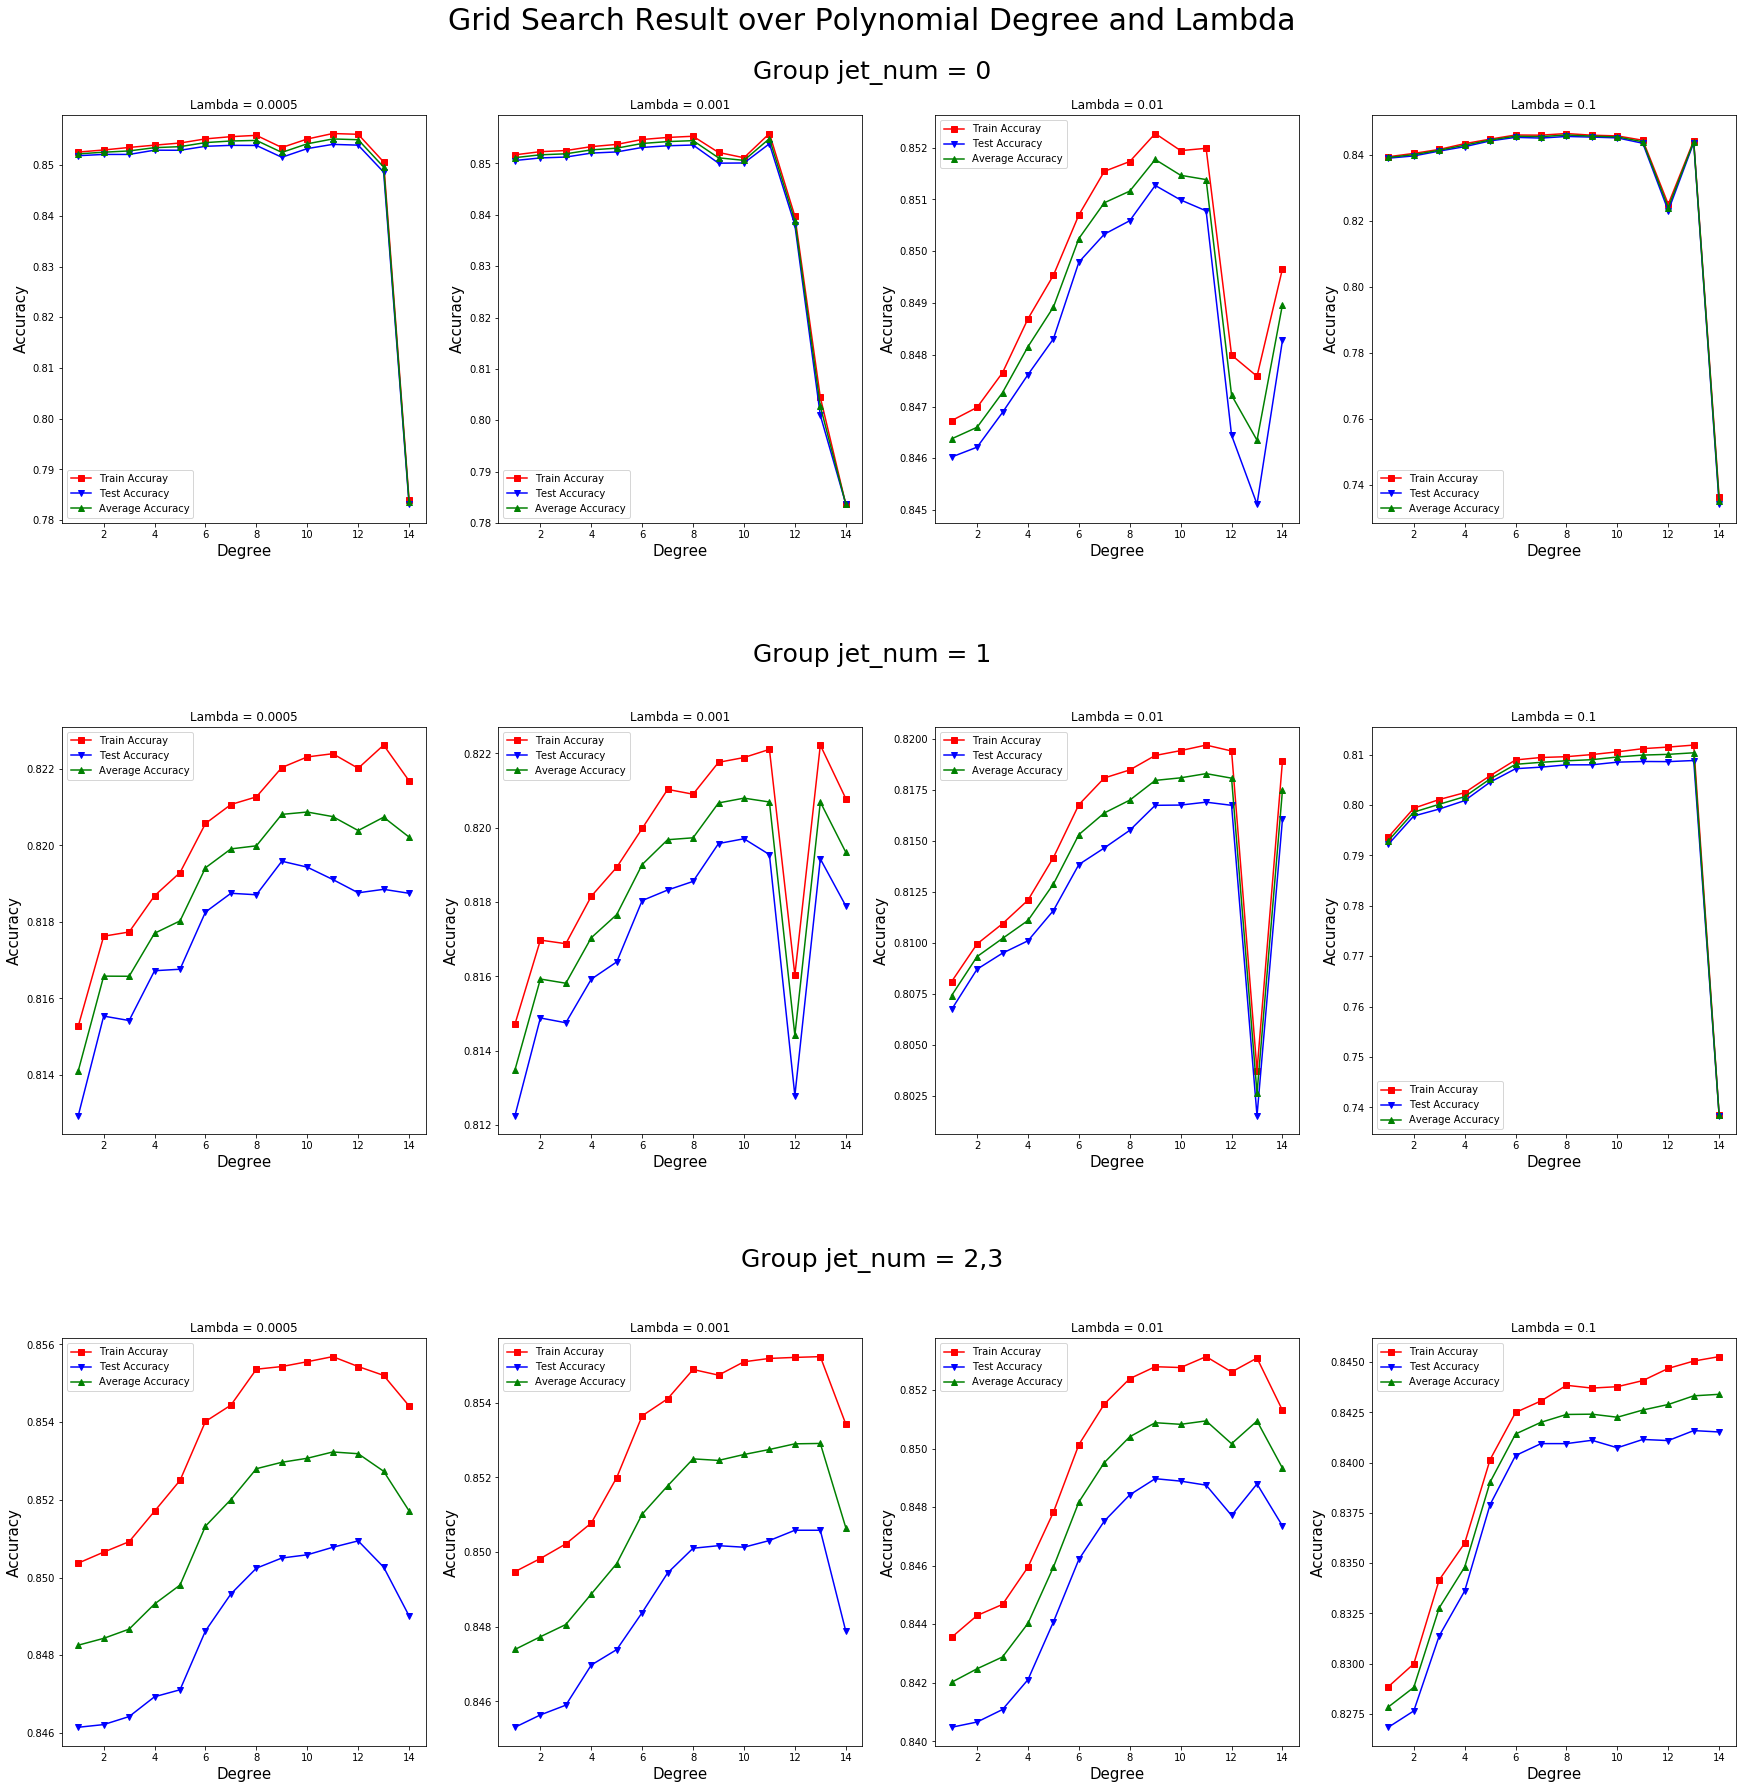

In [25]:
plot_gridsearch(acc_tr,acc_te,degrees,lambdas)